# M3 paper example 1

In [1]:
import time
import numpy as np
from qiskit import *
import mthree

In [2]:
from qiskit.quantum_info import Statevector

In [3]:
from qiskit.ignis.mitigation.expval import (expval_meas_mitigator_circuits ,
                                            TensoredExpvalMeasMitigator,
                                            ExpvalMeasMitigatorFitter, expectation_value)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [5]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = IBMQ.get_provider(group='deployed')

## Set backend and define circuit

In [7]:
backend = provider.backend.ibmq_mumbai

In [8]:
qubits= [1,4,7,10,12,13,14,11,8,5,3,2]

In [9]:
N = 12
qc = QuantumCircuit(N)

qc.x(range(0, N))
qc.h(range(0, N))

for kk in range(N//2,0,-1):
    qc.ch(kk, kk-1)
for kk in range(N//2, N-1):
    qc.ch(kk, kk+1)
qc.draw(fold=-1)

┌───┐┌───┐                         ┌───┐
 q_0: ┤ X ├┤ H ├─────────────────────────┤ H ├
      ├───┤├───┤                    ┌───┐└─┬─┘
 q_1: ┤ X ├┤ H ├────────────────────┤ H ├──■──
      ├───┤├───┤               ┌───┐└─┬─┘     
 q_2: ┤ X ├┤ H ├───────────────┤ H ├──■───────
      ├───┤├───┤          ┌───┐└─┬─┘          
 q_3: ┤ X ├┤ H ├──────────┤ H ├──■────────────
      ├───┤├───┤     ┌───┐└─┬─┘               
 q_4: ┤ X ├┤ H ├─────┤ H ├──■─────────────────
      ├───┤├───┤┌───┐└─┬─┘                    
 q_5: ┤ X ├┤ H ├┤ H ├──■──────────────────────
      ├───┤├───┤└─┬─┘                         
 q_6: ┤ X ├┤ H ├──■────■──────────────────────
      ├───┤├───┤     ┌─┴─┐                    
 q_7: ┤ X ├┤ H ├─────┤ H ├──■─────────────────
      ├───┤├───┤     └───┘┌─┴─┐               
 q_8: ┤ X ├┤ H ├──────────┤ H ├──■────────────
      ├───┤├───┤          └───┘┌─┴─┐          
 q_9: ┤ X ├┤ H ├───────────────┤ H ├──■───────
      ├───┤├───┤               └───┘┌─┴─┐     
q_10: ┤ X ├┤ H ├────────────────────┤ H ├──■──
      ├───┤├───┤                    └───┘┌─┴─┐
q_11: ┤ X ├┤ H ├─────────────────────────┤ H ├
      └───┘└───┘                         └───┘

In [10]:
state = Statevector.from_instruction(qc)
ideal_expval = expectation_value(state.probabilities_dict())[0]
ideal_expval

0.44628906249999983

In [11]:
#add measurements to circuit

In [12]:
qc.measure_all()

## Get raw data

In [13]:
raw_counts = execute([qc]*100, backend, shots=8192, initial_layout=qubits).result().get_counts()

In [14]:
raw_dist = []
for kk in range(100):
    raw_dist.append(expectation_value(raw_counts[kk])[0])

## Mitigate using Ignis tensored expval

In [15]:
circs, labels = expval_meas_mitigator_circuits(12, method='tensored')

In [16]:
job = execute(circs, backend, shots=8192, initial_layout=qubits)

In [17]:
fitter = ExpvalMeasMitigatorFitter(job.result(), labels).fit()

In [18]:
tn_dist = []
st = time.time()
for kk in range(100):
    tn_dist.append(expectation_value(raw_counts[kk], meas_mitigator=fitter)[0])
print('TN time:', (time.time()-st)/100)

TN time: 3.37315623998642


## Mitigate using M3 and same calibration matrices as Ignis tensored

In [19]:
mit = mthree.M3Mitigation(None)

In [20]:
mats = [None]*16

for kk, mat in enumerate(fitter._assignment_mats):
    mats[qubits[kk]] = mat

In [21]:
mit.single_qubit_cals = mats

In [41]:
m3_dist = []
st = time.time()
for kk in range(100):
    m3_counts = mit.apply_correction(raw_counts[kk], qubits)
    m3_dist.append(expectation_value(m3_counts)[0])
print('M3 time:', (time.time()-st)/100)

M3 time: 0.013745360374450684


In [42]:
num_counts = []
for cnt in raw_counts:
    num_counts.append(len(cnt))

In [43]:
np.mean(num_counts)

697.1

### Take a look at one of the subspace A-matrices used

In [27]:
A3, _ = mit.reduced_cal_matrix(raw_counts[-1], qubits)

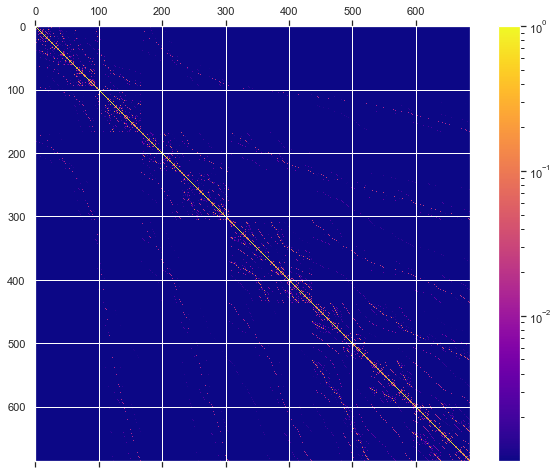

In [37]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(10,8))
mat = ax.matshow(A3, cmap='plasma', norm=LogNorm(vmin=A3[A3>1e-3].min(), vmax=1))
cbar = plt.colorbar(mat);

## Simulation with no measurement error (gate errors only)

In [29]:
from qiskit.providers.aer.noise import NoiseModel
sim = Aer.get_backend('qasm_simulator')

In [30]:
nm = NoiseModel.from_backend(backend)

In [31]:
for key, val in nm._local_readout_errors.items():
    nm._local_readout_errors[key]._probabilities = np.identity(2)

In [32]:
nm_meas_counts = execute([qc]*100, sim, noise_model=nm, shots=8192).result().get_counts()

In [33]:
no_meas_dist = []
st = time.time()
for kk in range(100):
    no_meas_dist.append(expectation_value(nm_meas_counts[kk])[0])

## Generate plot

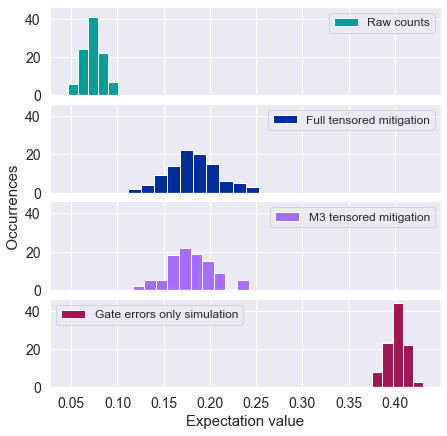

In [34]:
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(4, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].hist(raw_dist, bins=5, color='#009d9a')
axs[0].legend(['Raw counts'], fontsize=12)

axs[1].hist(tn_dist, bins=10, color='#002d9c')
axs[1].legend(['Full tensored mitigation'], fontsize=12)

axs[2].hist(m3_dist, bins=10, color='#a56eff')
axs[2].legend(['M3 tensored mitigation'], fontsize=12)
axs[2].set_ylabel('                   Occurrences', fontsize=15)

axs[3].hist(no_meas_dist, bins=5, color='#9f1853')
axs[3].legend(['Gate errors only simulation'], fontsize=12)
axs[3].set_xlabel('Expectation value', fontsize=15)
for ax in axs:
    ax.label_outer()
    ax.tick_params(labelsize=14);

## Look at how mitigation performs verses max Hamming distance

In [35]:
m3_weighted_dist = []
for dist in range(13):
    _temp = []
    for kk in range(100):
        m3_counts = mit.apply_correction(raw_counts[kk], qubits, distance=dist)
        _temp.append(expectation_value(m3_counts)[0])
    m3_weighted_dist.append(_temp)

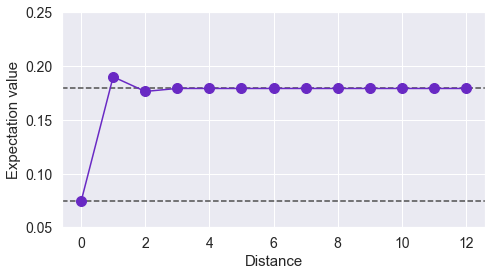

In [38]:
out = np.array([np.mean(m3_weighted_dist[kk]) for kk in range(13)])
fig = plt.figure(figsize=(7,4))
plt.axhline(np.mean(m3_dist), color='0.3', linestyle='dashed')
plt.axhline(np.mean(raw_dist), color='0.3', linestyle='dashed')
plt.plot(range(13), out, 'o-', ms=10, color='#6929c4')
plt.ylim([0.05,0.25])
for ax in fig.get_axes():
    ax.label_outer()
    ax.tick_params(labelsize=14)
    
plt.xlabel('Distance', fontsize=15);
plt.ylabel('Expectation value', fontsize=15);
fig.tight_layout()